In [1]:
import sys
sys.path.append('../../..')

import numpy as np

from olfactory_navigation.environment import Environment
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.agents.model_based_util.pomdp import Model
from olfactory_navigation.simulation import run_test
from olfactory_navigation.test_setups import run_all_starts_test

from matplotlib import pyplot as plt
from matplotlib import colors, patches
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(2)

## Variables

In [3]:
space_shape = np.array([101,101])
cells = np.array([7,7])

source_radius = 2
source_cell_resolution = np.array([7,7])

data_mean = [50,50]
data_covariance = 50

## Model

In [4]:
def generate_model(
        space_shape : np.ndarray,
        cells: np.ndarray,
        source_radius: int,
        source_cell_resolution: np.ndarray,
        data_mean: list,
        data_covariance: int
        ) -> Model:

    # Building probability map
    indices = np.arange(space_shape[0])
    x,y = np.meshgrid(indices, indices)
    pos = np.dstack((x, y))
    rv = multivariate_normal(data_mean, data_covariance)
    probability_map = rv.pdf(pos)

    # Normalize to have 1 at the center
    probability_map /= np.max(probability_map)

    # Building a grid-cell-mapping
    def build_grid_mapping(space_shape: np.ndarray = np.array([101,101]),
                       cells: np.ndarray = np.array([3,3]),
                       source_position: np.ndarray = np.array([50,50]),
                       source_radius: int = 4,
                       source_cell_resolution: np.ndarray = np.array([3,3])
                       ) -> np.ndarray:
        # Finding the sizes of the cells
        cell_size_standard = (space_shape / cells).astype(int)
        cell_size_overflow = (space_shape % cells).astype(int)

        # Determining cell sizes
        cell_sizes = []
        for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
            sizes = np.repeat(ax_size, ax_cells)
            if ax_overflow > 0:
                sizes[:int(np.floor(ax_overflow/2))] += 1
                sizes[-int(np.ceil(ax_overflow/2)):] += 1
            cell_sizes.append(sizes)

        # Finding the edges of the cells and filling a grid with ids
        cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

        lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T
        upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in cell_edges], indexing='ij')]).T

        grid_cells = np.full(space_shape, -1)
        for i, (lower_b, upper_b) in enumerate(zip(lower_bounds, upper_bounds)):
            slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

            # Grid to cell mapping
            grid_cells[*slices] = i

        # Finding cell the replace
        source_cell_id = grid_cells[*source_position]
        source_cell = np.array(np.unravel_index(source_cell_id, cells))

        # Finding center and replacing with closest side
        source_cell_shape = np.array([sizes[int(ax_id)] for sizes, ax_id in zip(cell_sizes, source_cell)])

        # Splitting the center cell grid into subcells
        sub_cell_size_standard = (source_cell_shape / source_cell_resolution).astype(int)
        sub_cell_size_overflow = (source_cell_shape % source_cell_resolution).astype(int)

        sub_cell_sizes = []
        for ax_cells, ax_size, ax_overflow in zip(source_cell_resolution, sub_cell_size_standard, sub_cell_size_overflow):
            sizes = np.repeat(ax_size, ax_cells)
            if ax_overflow > 0:
                sizes[:int(np.floor(ax_overflow/2))] += 1
                sizes[-int(np.ceil(ax_overflow/2)):] += 1
            sub_cell_sizes.append(sizes)

        # Finding the edges of the cells and filling a grid with ids
        sub_cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in sub_cell_sizes]

        sub_cell_lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in sub_cell_edges], indexing='ij')]).T
        sub_cell_upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in sub_cell_edges], indexing='ij')]).T

        sub_grid_cells = np.full(source_cell_shape, -1)
        for i, (lower_b, upper_b) in enumerate(zip(sub_cell_lower_bounds, sub_cell_upper_bounds)):
            slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

            # Grid to cell mapping
            sub_grid_cells[*slices] = i + np.prod(cells)

        # Injecting the sub_grid in the grid
        grid_cells[*[slice(lower_b, upper_b) for lower_b, upper_b in zip(lower_bounds[source_cell_id], upper_bounds[source_cell_id])]] = sub_grid_cells

        # Spacial indices
        spacial_indices = list(np.ndindex(tuple(space_shape)))
        spacial_indices_array = np.array(spacial_indices).astype(int)

        # Indices are at source
        at_source = np.sum((source_position[None,:] - spacial_indices_array) ** 2, axis=1) <= source_radius ** 2
        grid_cells[*spacial_indices_array[at_source].T] = -1

        return grid_cells

    # Generating state labels
    # Get the list of all indices
    indices_list = list(np.ndindex((*cells, *cells)))

    cell_indices = list(np.ndindex((*cells,)))
    source_cell_indices = list(np.ndindex((*source_cell_resolution,)))

    state_labels = []
    for (s_y, s_x) in cell_indices:
        for (a_y, a_x) in cell_indices:
            state_labels.append(f's_{s_y}_{s_x}-a_{a_y}_{a_x}')
        state_labels += [f's_{s_y}_{s_x}-sr_{source_y}_{source_x}' for (source_y, source_x) in source_cell_indices]
    state_labels.append('goal')

    # Generating action labels
    action_set = np.array([
        [-1,  0], # North
        [ 0,  1], # East
        [ 1,  0], # South
        [ 0, -1]  # West
    ])
    action_labels = [
        'North',
        'East',
        'South',
        'West'
    ]

    # Finding cell centers
    def find_cell_centers(space_shape: np.ndarray = np.array([101,101]),
                        cells: np.ndarray = np.array([3,3])):

        # Finding the sizes of the cells
        cell_size_standard = (space_shape / cells).astype(int)
        cell_size_overflow = (space_shape % cells).astype(int)

        # Determining cell sizes
        cell_sizes = []
        for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
            sizes = np.repeat(ax_size, ax_cells)
            sizes[:int(np.floor(ax_overflow/2))] += 1
            sizes[-int(np.ceil(ax_overflow/2)):] += 1
            cell_sizes.append(sizes)

        # Finding the edges of the cells and filling a grid with ids
        cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

        lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T

        cell_centers = lower_bounds + np.floor(cell_size_standard / 2).astype(int)
        return cell_centers

    # Building transition probabilities
    source_positions = find_cell_centers(space_shape=space_shape,
                                     cells=cells)

    # Spacial indices
    spacial_indices = list(np.ndindex(tuple(space_shape)))
    spacial_indices_array = np.array(spacial_indices).astype(int)

    # Set the transition probability matrix
    cell_count = np.prod(cells) + np.prod(source_cell_resolution) # ! Plus the sub cells zones of the source cell
    state_count = len(state_labels)
    action_count = len(action_set)
    transition_probabilities = np.zeros((state_count, action_count, state_count))

    for source_i, source_pos in enumerate(source_positions):
        grid_cells = build_grid_mapping(space_shape=space_shape,
                                        cells=cells,
                                        source_position=source_pos,
                                        source_radius=source_radius)
        cells_from_indices = grid_cells[*spacial_indices_array.T]

        move_probabilities = []
        for move in action_set:
            # Applying the moves to the indices
            moved_indices = spacial_indices_array + move
            moved_indices_clipped = np.clip(moved_indices, 0, space_shape-1)

            # Converting moved indices to cell indices
            cells_from_indices_after_move = grid_cells[*moved_indices_clipped.T]

            # Building a confusion matrix of the moves
            conf = confusion_matrix(cells_from_indices, cells_from_indices_after_move, labels=[-1] + list(np.arange(cell_count)), normalize='true')
            move_probabilities.append(conf[:,None,:])

        # Stack probabilities
        move_probabilities = np.hstack(move_probabilities)

        # In case a cell is not used, make the transition loop on itself
        zero_move_probabilities = np.argwhere(move_probabilities.sum(axis=-1) == 0).T
        move_probabilities[zero_move_probabilities[0], zero_move_probabilities[1], zero_move_probabilities[0]] = 1.0

        # Set the values in the transition matrix
        source_slice = slice((source_i * cell_count), ((source_i + 1) * cell_count))
        transition_probabilities[source_slice, :, source_slice] = move_probabilities[1:,:,1:]
        transition_probabilities[source_slice, :, -1] = move_probabilities[1:,:,0]
        transition_probabilities[-1, :, -1] = 1.0

    assert np.all(transition_probabilities.sum(axis=-1).round(8) == 1.0)

    # Observations
    threshold = 3e-6

    # Compute observation matrix
    if not isinstance(threshold, list):
        threshold = [threshold]

    # Ensure 0.0 and 1.0 begin and end the threshold list
    if threshold[0] != -np.inf:
        threshold = [-np.inf] + threshold

    if threshold[-1] != np.inf:
        threshold = threshold + [np.inf]

    #  Observation labels
    observation_labels = ['nothing']
    if len(threshold) > 3:
        for i,_ in enumerate(threshold[1:-1]):
            observation_labels.append(f'something_l{i}')
    else:
        observation_labels.append('something')

    # Adding the agent position to the oservation labels
    agent_state_labels = [label.split('-')[1] for label in state_labels[:np.prod(cells)]]
    all_observation_labels = []
    for obs in observation_labels:
        for agent_state in agent_state_labels:
            all_observation_labels.append(f'{agent_state}-{obs}')

    observation_labels = all_observation_labels

    # Add goal
    observation_labels.append('goal')

    # Observation probabilities
    # Finding the sizes of the cells
    cell_size_standard = (space_shape / cells).astype(int)
    cell_size_overflow = (space_shape % cells).astype(int)

    # Determining cell sizes
    cell_sizes = []
    for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
        sizes = np.repeat(ax_size, ax_cells)
        sizes[:int(np.floor(ax_overflow/2))] += 1
        sizes[-int(np.ceil(ax_overflow/2)):] += 1
        cell_sizes.append(sizes)

    # Finding the edges of the cells and filling a grid with ids
    cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

    lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T
    upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in cell_edges], indexing='ij')]).T


    cell_probabilities = np.full(cells, -1, dtype=float)
    for cell, lower_b, upper_b in zip(list(np.ndindex(tuple(cells))), lower_bounds, upper_bounds):
        slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

        # TODO: Make it flexible to multi thresh
        cell_probabilities[*cell] = np.average(probability_map[*slices])

    indices_array = np.array(indices_list)
    relative_indices = indices_array[:,:len(cells)] - indices_array[:,len(cells):]

    # Shifting the relative positions by the position of the center
    center_pos = (cells / 2).astype(int)
    centered_positions = relative_indices + center_pos

    # Filtering to the valid centered positions
    valid_positions = np.all((centered_positions >= 0) & (centered_positions < cells), axis=1)
    filtered_centered_positions = centered_positions[valid_positions]
    filtered_indices_array = indices_array[valid_positions]

    # Gathering the cell_probabilities
    odor_probabilities = np.zeros((*cells, *cells), dtype=float)
    odor_probabilities[*filtered_indices_array.T] = cell_probabilities[*filtered_centered_positions.T]

    # Generating an empty observation matrix
    observations = np.zeros((len(state_labels), len(action_set), len(observation_labels)))

    # Filling the something/nothing observations
    agent_cells = indices_array[:np.prod(cells),2:]
    for obs_i, agent_cell in enumerate(agent_cells):
        # For observation matrix
        agent_ids_in_states = (np.arange(np.prod(cells)) * cell_count) + obs_i

        # To read odor probability matrix
        agent_ids_in_space = np.all(indices_array[:,2:] == agent_cell, axis=1)
        filtered_agent_ids_in_space = indices_array[agent_ids_in_space]

        # Setting the probabilities in the matrix
        probabilities_at_agent_position = odor_probabilities[*filtered_agent_ids_in_space.T][:,None]
        observations[agent_ids_in_states,:,obs_i] = 1 - probabilities_at_agent_position # Nothing
        observations[agent_ids_in_states,:,obs_i+len(agent_cells)] = probabilities_at_agent_position # Something

        # Finding sub-cells of the source cell
        sub_cell_source_ids = ((obs_i * cell_count) + np.prod(cells)) + np.arange(np.prod(source_cell_resolution))
        observations[sub_cell_source_ids,:,obs_i] = 1 - probabilities_at_agent_position[obs_i] # Nothing
        observations[sub_cell_source_ids,:,obs_i+len(agent_cells)] = probabilities_at_agent_position[obs_i] # Something

        # Finding the cells  where the agent is at the source
        agent_at_source_id = (obs_i * cell_count) + obs_i
        observations[agent_at_source_id,:,obs_i] = 1.0 # Nothing
        observations[agent_at_source_id,:,obs_i+len(agent_cells)] = 0.0 # Something


    # Goal observations
    observations[-1,:,0] = 0.0
    observations[:,:,-1] = 0.0
    observations[-1,:,-1] = 1.0 # Goal

    assert np.all(observations.sum(axis=-1).round(8) == 1.0)

    # Building model
    model = Model(
        states = state_labels,
        actions = action_labels,
        observations = observation_labels,
        transitions = transition_probabilities,
        observation_table = observations,
        end_states = [len(state_labels)-1], # The very last state is the goal state
        # start_probabilities = start_probabilities,
        seed=12131415
    )

    return model

In [5]:
model = generate_model(
    space_shape=space_shape,
    cells=cells,
    source_radius=source_radius,
    source_cell_resolution=source_cell_resolution,
    data_mean=data_mean,
    data_covariance=data_covariance
)

## Agent

In [6]:
def generate_fake_data(
        space_shape: np.ndarray,
        data_mean: list,
        data_covariance,
        samples: int
        ) -> np.ndarray:
    x,y = np.meshgrid(np.arange(space_shape[0]), np.arange(space_shape[1]))
    pos = np.dstack((x, y))
    rv = multivariate_normal(data_mean, data_covariance)
    probability_map = rv.pdf(pos)

    # Normalize to have 1 at the center
    probability_map /= np.max(probability_map)

    multiple_samples = (np.random.random((samples, *space_shape)) < probability_map).astype(float)

    return multiple_samples

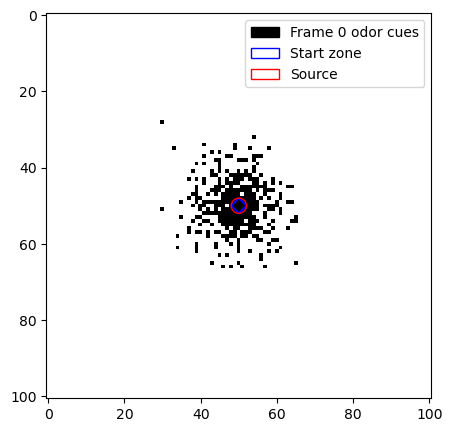

In [7]:
artificial_data = generate_fake_data(space_shape=space_shape,
                                     data_mean=data_mean,
                                     data_covariance=data_covariance,
                                     samples=1000)

artificial_env  = Environment(data_file=artificial_data,
                              data_source_position=[50, 50],
                              source_radius=source_radius,
                              shape=space_shape,
                              boundary_condition='stop',
                              start_zone='data_zone',
                              odor_present_threshold=3e-1)

artificial_env.plot()

In [8]:
ag = FSVI_Agent(environment=artificial_env,
                threshold=3e-8,
                space_aware=True,
                spacial_subdivisions=cells,
                model=model)

In [9]:
_ = ag.train(expansions=300, use_gpu=True)

[09/17/2024, 16:25:08] MDP_policy, not provided. Solving MDP with Value Iteration...
[09/17/2024, 16:25:08] Sending Model to GPU...
[09/17/2024, 16:25:09]     > Done in 0.484s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 4803-state, 4-action
  - Converged in 918 iterations and 1.2013 seconds
  - Took on average 0.0013s per iteration


Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Summary of Point Based Value Iteration run
  - Model: 4803 state, 4 action, 99 observations
  - Converged or stopped after 300 expansion steps and 300 backup steps.
  - Resulting value function has 1600 alpha vectors.
  - Converged in 215.4867s

  - Expand function took on average 0.0128s and yielded on average 1160.59 beliefs per iteration. (0.0001s/it/belief)
  - Backup function took on average 0.7054s and yielded on average 5.32 alpha vectors per iteration. (0.0009s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


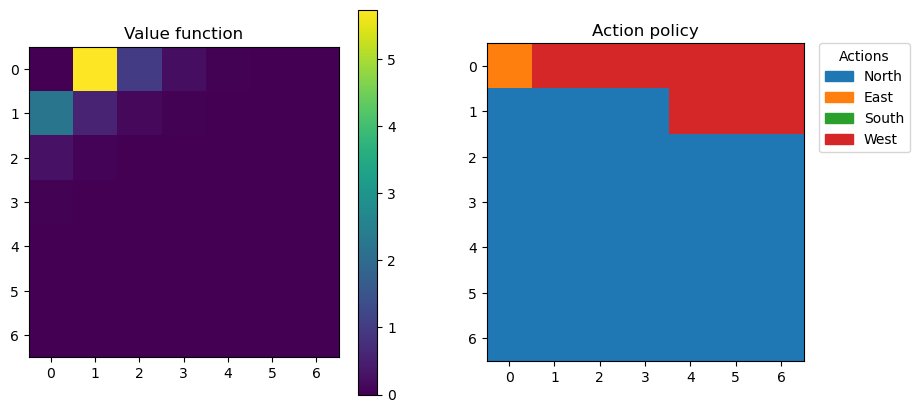

In [10]:
# CUSTOM PLOT
COLOR_LIST = [{
    'name': item.replace('tab:',''),
    'id': item,
    'hex': value,
    'rgb': [int(value.lstrip('#')[i:i + (len(value)-1) // 3], 16) for i in range(0, (len(value)-1), (len(value)-1) // 3)]
    } for item, value in colors.TABLEAU_COLORS.items()] # type: ignore

COLOR_ARRAY = np.array([c['rgb'] for c in COLOR_LIST])

# VF
vf = ag.value_function
new_shape = cells

# ! Select here which source to plot
source_policy = [0,0]
source_policy_id = np.arange(np.prod(cells)).reshape(cells)[*source_policy]
source_state_start = source_policy_id * np.prod(cells)

value_table = np.max(vf.alpha_vector_array, axis=0)[vf.model.state_grid[:,source_state_start:source_state_start+np.prod(cells)]].reshape(new_shape)
best_action_table = np.array(vf.actions)[np.argmax(vf.alpha_vector_array, axis=0)][vf.model.state_grid[:,source_state_start:source_state_start+np.prod(cells)]].reshape(new_shape)
best_action_colors = COLOR_ARRAY[best_action_table]

dimensions = new_shape

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(5*2, 5), width_ratios=(0.55,0.45))

# Ticks
x_ticks = np.arange(0, dimensions[1], (1 if dimensions[1] < 10 else int(dimensions[1] / 10)))
y_ticks = np.arange(0, dimensions[0], (1 if dimensions[0] < 5 else int(dimensions[0] / 5)))

ax1.set_title('Value function')
ax1_plot = ax1.imshow(value_table)

if dimensions[0] >= dimensions[1]: # If higher than wide
    plt.colorbar(ax1_plot, ax=ax1)
else:
    plt.colorbar(ax1_plot, ax=ax1, location='bottom', orientation='horizontal')

ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)

ax2.set_title('Action policy')
ax2.imshow(best_action_colors)
p = [ patches.Patch(color=COLOR_LIST[int(i)]['id'], label=str(vf.model.action_labels[int(i)])) for i in vf.model.actions]
ax2.legend(handles=p, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Actions')
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)

plt.show()

### Validation on the artificial data

In [11]:
hist = run_all_starts_test(ag,
                           horizon=1000,
                           use_gpu=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 12.065s:
Simulations reached goal: 10188/10188 (0 failures (reached horizon: 0)) (100.00% success)
 - Average step count:                 214.794 +- 116.67 (Successfull only: 214.794 +- 116.68)
 - Extra steps:                        166.236 +- 110.99 (Successful only: 166.236 +- 111.00)
 - Average discounted rewards (ADR):   0.202 +- 0.20 (Successfull only: 0.202 +- 0.20)
 - Tmin/T:                             0.291 +- 0.18 (Successful only: 0.291 +- 0.18)


## Test

In [17]:
shift = np.array([-7,-7])

shifted_artificial_data = np.zeros(artificial_data.shape)
trimmed_artificial_data = artificial_data[:, *[slice(0, -s) if s >=0 else slice(-s, shape) for shape, s in zip(space_shape, shift)]]
shifted_artificial_data[:, *[slice(s, shape) if s >=0 else slice(0, s) for shape, s in zip(space_shape, shift)]] = trimmed_artificial_data

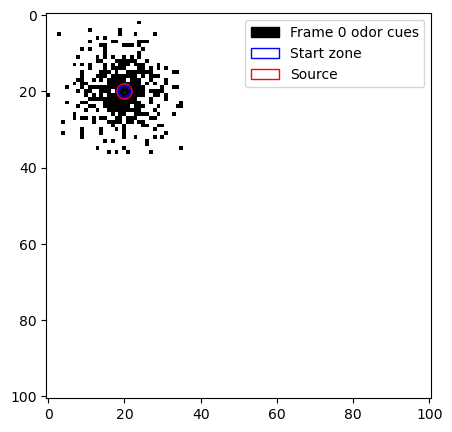

In [18]:
shifted_artificial_env  = Environment(data_file=shifted_artificial_data,
                                      data_source_position=(np.array([50,50]) + shift).tolist(),
                                      source_radius=source_radius,
                                      shape=space_shape,
                                      boundary_condition='stop',
                                      start_zone='data_zone',
                                      odor_present_threshold=3e-1)

shifted_artificial_env.plot()

In [19]:
hist = run_all_starts_test(ag,
                           environment=shifted_artificial_env,
                           horizon=1000,
                           use_gpu=True)

Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 10.591s:
Simulations reached goal: 10188/10188 (0 failures (reached horizon: 0)) (100.00% success)
 - Average step count:                 200.603 +- 89.03 (Successfull only: 200.603 +- 89.03)
 - Extra steps:                        134.201 +- 83.18 (Successful only: 134.201 +- 83.18)
 - Average discounted rewards (ADR):   0.186 +- 0.16 (Successfull only: 0.186 +- 0.16)
 - Tmin/T:                             0.363 +- 0.20 (Successful only: 0.363 +- 0.20)


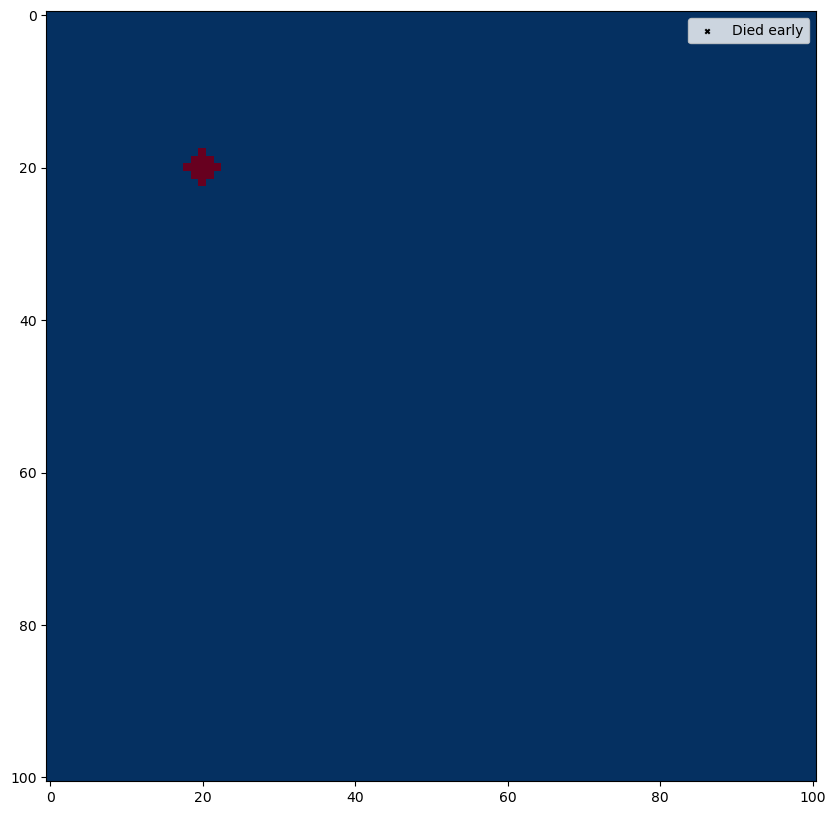

In [20]:
_, ax = plt.subplots(1,1, figsize=(10,10))
hist.plot_successes(ax)

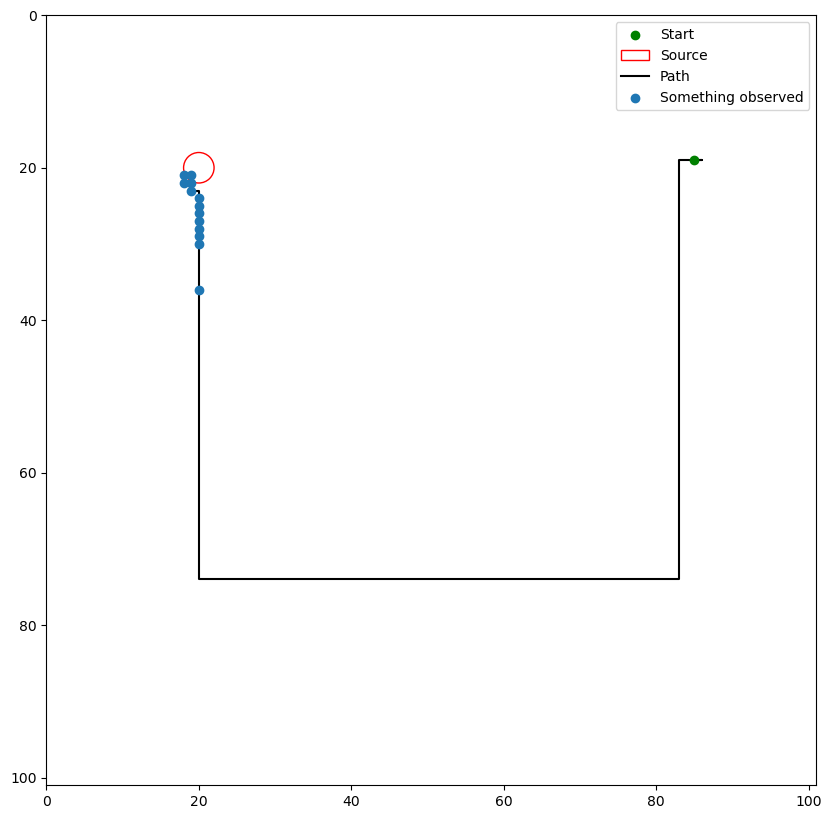

In [21]:
_, ax = plt.subplots(1,1, figsize=(10,10))
hist.plot(2000, ax=ax)

In [22]:
hist.analysis_df

,y,x,optimal_steps_count,converged,reached_horizon,steps_taken,discounted_rewards,extra_steps,t_min_over_t
mean,NaN,NaN,NaN,1.0,0.0,200.603455,0.186000,134.201413,0.362742
standard_deviation,NaN,NaN,NaN,0.0,0.0,89.026469,0.158015,83.179611,0.196275
success_mean,NaN,NaN,NaN,1.0,0.0,200.603455,0.186000,134.201413,0.362742
success_standard_deviation,NaN,NaN,NaN,0.0,0.0,89.030839,0.158022,83.183694,0.196285
run_0,0.0,0.0,38.0,True,False,79.000000,0.452044,41.000000,0.481013
...,...,...,...,...,...,...,...,...,...
run_10183,100.0,96.0,154.0,True,False,302.000000,0.048065,148.000000,0.509934
run_10184,100.0,97.0,155.0,True,False,307.000000,0.045709,152.000000,0.504886
run_10185,100.0,98.0,156.0,True,False,300.000000,0.049041,144.000000,0.520000
run_10186,100.0,99.0,157.0,True,False,311.000000,0.043908,154.000000,0.504823
